<a href="https://colab.research.google.com/github/christinezuzart/DeepLearning/blob/master/CleanedNLPULMFitGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import io

dfTrain = pd.read_csv('/content/gdrive/My Drive/Data/drugsComTrainClean_raw.csv')
dfTest = pd.read_csv('/content/gdrive/My Drive/Data/drugsComTestClean_raw.csv') 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
train_texts = dfTrain.loc[ : , 'review'].values
train_labels = dfTrain.loc[ : , 'condition'].values

test_texts = dfTest.loc[ : , 'review'].values
test_labels = dfTest.loc[ : , 'condition'].values

col_names = ['labels','text']
df_train = pd.DataFrame({'text':train_texts, 'labels':train_labels}, columns=col_names)
df_test = pd.DataFrame({'text':test_texts, 'labels':test_labels}, columns=col_names)

df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

In [5]:
unique_train_labels_list = df_train.labels.unique()
unique_test_labels_list = df_test.labels.unique()

df_test_new = pd.DataFrame(columns=['labels','text'])

for ind in df_test.index: 
  if df_test['labels'][ind] in unique_train_labels_list :
   new_row = {'labels': df_test['labels'][ind], 'text':df_test['text'][ind]}
   df_test_new = df_test_new.append(new_row, ignore_index=True)

print(df_test_new.head())

                         labels                                               text
0                    Depression  "I&#039;ve tried a few antidepressants over th...
1  Crohn's Disease, Maintenance  "My son has Crohn&#039;s disease and has done ...
2       Urinary Tract Infection                      "Quick reduction of symptoms"
3                   Weight Loss  "Contrave combines drugs that were used for al...
4                 Birth Control  "I have been on this birth control for one cyc...


In [0]:
# a = df_test_new.labels.unique()
# print('\n'.join(map(str, a)))

In [0]:
from fastai.text import *

# Language model data
data_lm = TextLMDataBunch.from_df('./', train_df=df_train, valid_df=df_test_new)

In [0]:
# Language model
lang_learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


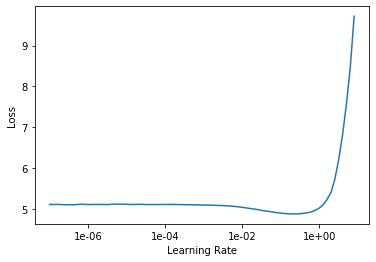

In [9]:
lang_learner.lr_find(start_lr=1e-8, end_lr=1e2)
lang_learner.recorder.plot()

In [10]:
lang_learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
lang_learner.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

lang_learner.unfreeze() 
lang_learner.fit_one_cycle(2, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.677010,3.527002,0.307432,11:12


epoch,train_loss,valid_loss,accuracy,time
0,3.201628,3.098289,0.360587,12:54
1,3.070693,2.996487,0.374368,12:58


In [0]:
lang_learner.save_encoder('fine_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=df_train, valid_df=df_test_new, vocab=data_lm.train_ds.vocab, min_freq=1, bs=32)

In [0]:
# Classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


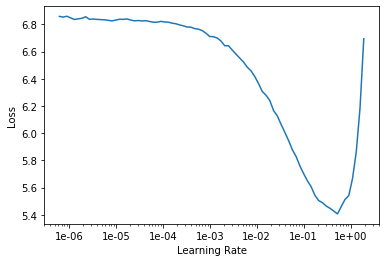

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_enc')

learn.freeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.989043,1.723378,0.609488,04:20


In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.715294,1.472869,0.666410,10:32
1,1.367701,1.238326,0.709750,10:53
2,1.178881,1.125301,0.734561,11:30


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.121296,1.133016,0.735125,05:09


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.171512,1.103547,0.741502,07:52


In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.024637,1.091188,0.744493,11:42
1,0.953407,1.073143,0.751096,10:55
2,0.983073,1.044979,0.757924,11:34
3,0.956593,1.045913,0.759899,11:51


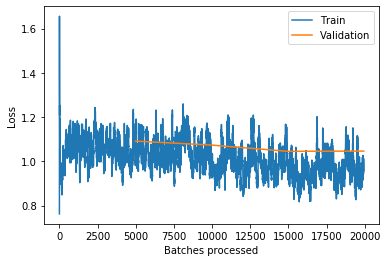

In [20]:
learn.recorder.plot_losses()

In [0]:
learn.export()

In [22]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,34,36,37,38,39,40,41,43,44,46,47,...,755,756,757,758,759,761,762,763,764,765,766,768,770,772,773,774,775,776,778,780,781,782,783,784,786,787,788,790,791,792,795,796,797,799,800,801,802,805,809,810
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1015,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
7,0,0,0,0,0,1733,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446,0,0,0,0,0,0,0,0,0,1,0,0,0,0
791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,0,0,0,0,0,0,0,0,0,0,0
796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0


In [23]:
# from fastai.vision import *

# preds, y, losses = learn.get_preds(with_loss = 1)
print(f"softmax predictions: {preds}")
print(f"indexed predictions:{predictions}")
print(f"targets:{targets}")

softmax predictions: tensor([[1.3931e-04, 4.4034e-08, 3.2655e-10,  ..., 4.6868e-10, 1.5637e-08,
         1.6651e-06],
        [2.1586e-04, 3.5576e-06, 1.9858e-08,  ..., 3.1536e-08, 1.0085e-06,
         2.7557e-04],
        [7.3554e-05, 7.1727e-09, 3.4460e-11,  ..., 4.5149e-11, 8.5710e-09,
         3.3757e-07],
        ...,
        [7.2420e-05, 1.3995e-07, 4.7871e-10,  ..., 4.7110e-10, 2.8365e-08,
         5.0595e-07],
        [1.4263e-02, 1.9691e-06, 1.1852e-08,  ..., 1.4841e-08, 2.0409e-06,
         2.4175e-04],
        [7.7150e-03, 5.2438e-06, 3.5307e-08,  ..., 4.0551e-08, 4.1645e-06,
         4.0330e-04]])
indexed predictions:tensor([491, 189, 501,  ..., 461, 510, 521])
targets:tensor([491, 189, 501,  ..., 189, 252, 645])


In [24]:
class_names = learn.data.classes
print(class_names)

['ADHD', 'AIDS Related Wasting', 'AV Heart Block', 'Abdominal Distension', 'Abnormal Uterine Bleeding', 'Abortion', 'Acetaminophen Overdose', 'Acne', 'Actinic Keratosis', 'Acute Coronary Syndrome', 'Acute Lymphoblastic Leukemia', 'Acute Nonlymphocytic Leukemia', 'Acute Promyelocytic Leukemia', "Addison's Disease", 'Adrenocortical Insufficiency', 'Adult Human Growth Hormone Deficiency', 'Aggressive Behavi', 'Agitated State', 'Agitation', 'Alcohol Dependence', 'Alcohol Withdrawal', 'Allergic Reactions', 'Allergic Rhinitis', 'Allergic Urticaria', 'Allergies', 'Alopecia', 'Alpha-1 Proteinase Inhibitor Deficiency', "Alzheimer's Disease", 'Amebiasis', 'Amenorrhea', 'Amyotrophic Lateral Sclerosis', 'Anal Fissure and Fistula', 'Anal Itching', 'Anaphylaxis', 'Anaplastic Astrocytoma', 'Anaplastic Oligodendroglioma', 'Androgenetic Alopecia', 'Anemia', 'Anemia Associated with Chronic Renal Failure', 'Anemia, Chemotherapy Induced', 'Anemia, Sickle Cell', 'Anesthesia', 'Anesthetic Adjunct', 'Angina'

In [25]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(targets, predictions)
print(confusion_matrix)


[[1015    0    0    0 ...    0    0    0    0]
 [   1    0    0    0 ...    0    0    0    0]
 [   0    0  392    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 ...
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    2    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]]


In [0]:
# metrics.classification_report(targets, predictions, target_names=class_names)
# metrics.classification_report(targets, predictions, target_names=unique_train_labels_list)

In [0]:
# interp = ClassificationInterpretation(learn, preds, y, losses)

# interp.plot_confusion_matrix()

In [0]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [30]:
learn.save("trained_model", return_path=True)

PosixPath('models/trained_model.pth')

In [0]:
# from google.colab import files

# uploaded = files.upload()

In [0]:
#from fastai.text import *

# model_save_name = 'export.pkl'
# path = F"/content/gdrive/My Drive/{model_save_name}" 

# saved_learner = load_learner(io.StringIO(uploaded['export.pkl'].decode('utf-8')))



In [0]:
# saved_learner.predict("")

In [34]:
model_save_name = 'export.pkl'
path = F"/content/drive/My Drive/{model_save_name}" 
print(path)
learn.export(path)

/content/drive/My Drive/export.pkl
